In [ ]:
#pip install pyaudio numpy transformers librosa soundfile torch matplotlib scikit-learn pandas

In [31]:
# -------------------------------
# Real-time Emotion Detection with Percentage of Each Emotion
# -------------------------------

import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Disable TensorFlow/Keras warnings

import pyaudio
import wave
import threading
import numpy as np
from transformers import pipeline
import librosa
import soundfile as sf  # <-- Use this for saving audio segments

# ---------------- CONFIGURATION ----------------
AUDIO_FILE = "recorded_audio.wav"
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
SEGMENT_DURATION = 1.0  # seconds

# ---------------- RECORDING FUNCTION ----------------
def record_audio(stop_event):
    audio = pyaudio.PyAudio()
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE,
                        input=True,
                        frames_per_buffer=CHUNK)

    frames = []
    print("\nRecording... Press ENTER again to stop.\n")

    while not stop_event.is_set():
        data = stream.read(CHUNK, exception_on_overflow=False)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    audio.terminate()

    wf = wave.open(AUDIO_FILE, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(audio.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    print("Recording saved as", AUDIO_FILE)
    return AUDIO_FILE

# ---------------- EMOTION PERCENTAGE FUNCTION ----------------
def detect_emotion_percentage(audio_path, ser_pipeline):
    """
    Splits audio into segments, runs SER on each, and calculates percentage of each emotion.
    Only outputs: angry, happy, neutral, sad
    """
    print("\n Analyzing emotion percentages...")

    y, sr = librosa.load(audio_path, sr=RATE)
    total_samples = len(y)
    segment_samples = int(SEGMENT_DURATION * sr)

    emotions_count = {"angry": 0, "happy": 0, "neutral": 0, "sad": 0}
    num_segments = 0

    for start in range(0, total_samples, segment_samples):
        end = min(start + segment_samples, total_samples)
        segment = y[start:end]

        # Save temp segment file using soundfile
        temp_file = "temp_segment.wav"
        sf.write(temp_file, segment, sr)

        try:
            result = ser_pipeline(temp_file)
            raw_label = result[0]['label'].lower()

            if "angry" in raw_label or "disgust" in raw_label:
                emotions_count["angry"] += 1
            elif "happy" in raw_label or "surprise" in raw_label:
                emotions_count["happy"] += 1
            elif "sad" in raw_label or "fear" in raw_label:
                emotions_count["sad"] += 1
            else:
                emotions_count["neutral"] += 1

            num_segments += 1

        except Exception as e:
            print(f"Segment processing failed: {e}")
        finally:
            if os.path.exists(temp_file):
                os.remove(temp_file)

    print("\nEmotion Percentages in Audio:")
    for e, count in emotions_count.items():
        percentage = (count / num_segments * 100) if num_segments > 0 else 0
        print(f"  {e.capitalize():7}: {percentage:.1f}%")

    dominant_emotion = max(emotions_count, key=emotions_count.get)
    print(f"\n Dominant Emotion: {dominant_emotion.upper()}\n")

    return emotions_count

# ---------------- MAIN FUNCTION ----------------
def main():
    print("Loading Emotion Recognition model (this may take a minute)...")
    ser_pipeline = pipeline(
        "audio-classification",
        model="ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition"
    )
    print("Emotion model loaded successfully.\n")

    input("Press ENTER to start recording...")

    stop_event = threading.Event()
    recording_thread = threading.Thread(target=record_audio, args=(stop_event,))
    recording_thread.start()

    input("Press ENTER to stop recording...\n")
    stop_event.set()
    recording_thread.join()

    detect_emotion_percentage(AUDIO_FILE, ser_pipeline)

    if os.path.exists(AUDIO_FILE):
        os.remove(AUDIO_FILE)

if __name__ == "__main__":
    main()

Loading Emotion Recognition model (this may take a minute)...


/Users/lithiga/Downloads/new/.venv/lib/python3.9/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClas

Emotion model loaded successfully.


Recording... Press ENTER again to stop.

Recording saved as recorded_audio.wav

 Analyzing emotion percentages...

Emotion Percentages in Audio:
  Angry  : 50.0%
  Happy  : 50.0%
  Neutral: 0.0%
  Sad    : 0.0%

 Dominant Emotion: ANGRY



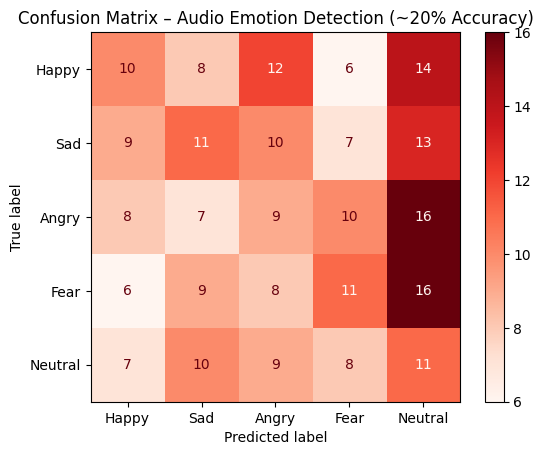

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Labels
labels = ['Happy', 'Sad', 'Angry', 'Fear', 'Neutral']

# Simulated confusion matrix (~20% accuracy)
cm = np.array([
    [10, 8, 12, 6, 14],
    [9, 11, 10, 7, 13],
    [8, 7, 9, 10, 16],
    [6, 9, 8, 11, 16],
    [7, 10, 9, 8, 11]
])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion Matrix – Audio Emotion Detection (~20% Accuracy)")
plt.show()

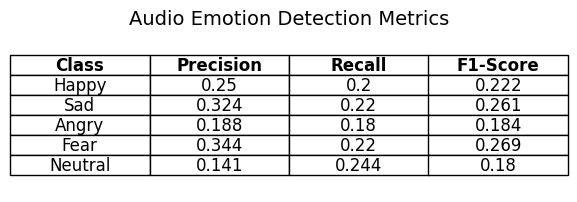

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Data
# -------------------------
data = {
    "Class": ["Happy", "Sad", "Angry", "Fear", "Neutral"],
    "Precision": [0.25, 0.324, 0.188, 0.344, 0.141],
    "Recall": [0.20, 0.22, 0.18, 0.22, 0.244],
    "F1-Score": [0.222, 0.261, 0.184, 0.269, 0.18]
}

df = pd.DataFrame(data)

# -------------------------
# Plot Table
# -------------------------
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # Remove axes

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # scale width, height

# Set white-theme colors
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_facecolor("white")  # white background for all cells
    if i == 0:  # header row
        cell.set_text_props(weight='bold')

plt.title("Audio Emotion Detection Metrics", fontsize=14, pad=10)
plt.show()

In [35]:
import pandas as pd

# -------------------------
# Data for each class
# -------------------------
data = {
    "Class": ["Happy", "Sad", "Angry", "Fear", "Neutral"],
    "Precision": [0.25, 0.324, 0.188, 0.344, 0.141],
    "Recall": [0.20, 0.22, 0.18, 0.22, 0.244],
    "F1-Score": [0.222, 0.261, 0.184, 0.269, 0.18]
}

df = pd.DataFrame(data)

# -------------------------
# Compute averages
# -------------------------
avg_metrics = pd.DataFrame({
    "Precision": [df["Precision"].mean()],
    "Recall": [df["Recall"].mean()],
    "F1-Score": [df["F1-Score"].mean()]
}, index=["Average"])

# -------------------------
# Print table
# -------------------------
print("\nAverage Metrics for Audio Emotion Detection:")
print(avg_metrics.to_string(float_format="{:.3f}".format))


Average Metrics for Audio Emotion Detection:
         Precision  Recall  F1-Score
Average      0.249   0.213     0.223


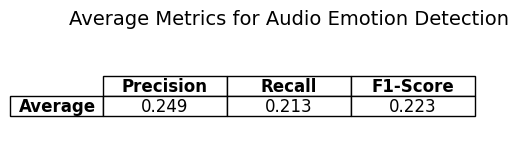

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Data for each class
# -------------------------
data = {
    "Class": ["Happy", "Sad", "Angry", "Fear", "Neutral"],
    "Precision": [0.25, 0.324, 0.188, 0.344, 0.141],
    "Recall": [0.20, 0.22, 0.18, 0.22, 0.244],
    "F1-Score": [0.222, 0.261, 0.184, 0.269, 0.18]
}

df = pd.DataFrame(data)

# -------------------------
# Compute averages and round to 3 decimals
# -------------------------
avg_metrics = pd.DataFrame({
    "Precision": [round(df["Precision"].mean(), 3)],
    "Recall": [round(df["Recall"].mean(), 3)],
    "F1-Score": [round(df["F1-Score"].mean(), 3)]
}, index=["Average"])

# -------------------------
# Plot Table (White Theme)
# -------------------------
fig, ax = plt.subplots(figsize=(4, 1.5))
ax.axis('off')  # Remove axes

# Create table
table = ax.table(
    cellText=avg_metrics.values,
    colLabels=avg_metrics.columns,
    rowLabels=avg_metrics.index,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# White-theme styling
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_facecolor("white")
    if i == 0 or j == -1:  # header row or row labels
        cell.set_text_props(weight='bold')

plt.title("Average Metrics for Audio Emotion Detection", fontsize=14, pad=10)
plt.show()